In [1]:
import numpy as np
from pylab import *  # plotting library 
from numba import jit
import matplotlib.animation as am

@jit(nopython = True)
def MCstep_jit(N, L, T,h, state, acceptedMoves, energy, magnetization):

    randomPositions = L  * np.random.random(2*N)
    randomArray = np.random.random(N)
    
    for k in range(N):

        i = int(randomPositions[2*k])
        j = int(randomPositions[2*k+1])
        
        dE = 2*state[i, j] * (state[(i+1)%L, j] + state[i-1, j] + state[i, (j+1)%L] + state[i, j-1]) + h*state[i,j]
        
        if dE <= 0 or np.exp(-dE/T) > randomArray[k]:
            acceptedMoves += 1
            newSpin = -state[i, j] # flip spin
            state[i, j] = newSpin
            energy += dE
            magnetization += 2*newSpin

    return state, acceptedMoves, energy, magnetization

@jit(nopython = True)
def raster_MCstep_jit(N, L, T, h, state, acceptedMoves, energy, magnetization):

    randomArray = np.random.random(N)
    
    L1 = L - 1
    for i in range(L):
        for j in range(L):
            
            # i+L1%L performs periodic BC's when array[-1] does not work

            dE = 2*state[i, j] * (state[(i+1)%L, j] + state[(i+L1)%L, j] + state[i, (j+1)%L] + state[i, (j+L1)%L])
        
            if dE <= 0 or w[dE] > randomArray[i*L + j]:
                acceptedMoves += 1
                newSpin = -state[i, j] # flip spin
                state[i, j] = newSpin
                energy += dE
                magnetization += 2*newSpin

    return state, acceptedMoves, energy, magnetization



class Ising2D (object):

    """Class that describes equilibrium statistical mechanics of the two-dimensional Ising model"""

    def __init__(self, L=32, temperature=10.0, field = 0):

        #np.random.seed(222)
        
        self.L = L
        self.N = L**2
        
        self.temperature = temperature
        self.field = field
        
        self.w = zeros(9) # store Boltzmann weights
        self.w[8] = exp(-8.0/self.temperature)
        self.w[4] = exp(-4.0/self.temperature)
        
        self.state = ones((self.L, self.L), int) # initially all spins up
        self.energy = - 2 * self.N
        self.magnetization = self.N
        
        self.reset()


    def increment_T(self, T_increment, reset = True):

        T_new = self.temperature + T_increment
        
        if T_new <= 0:
            T_new = self.temperature

        # self.w[8] = exp(-8.0/T_new)
        # self.w[4] = exp(-4.0/T_new)

        self.temperature = T_new
        if reset:
            self.reset()

    def increment_h(self, h_increment, reset = True):

        h_new = self.field + h_increment
        
        # self.w[8] = exp(-8.0/T_new)
        # self.w[4] = exp(-4.0/T_new)

        self.field = h_new
        if reset:
            self.reset()

            
    def reset(self):

        self.monteCarloSteps = 0
        self.acceptedMoves = 0
        self.energyArray = array([], int)
        self.magnetizationArray = array([], int)
            
            
    def monteCarloStep(self):

        N = self.N
        L = self.L
        w = self.w
        T = self.temperature
        h = self.field
        
        state = self.state
        acceptedMoves = self.acceptedMoves
        energy = self.energy
        magnetization = self.magnetization

        state, acceptedMoves, energy, magnetization = MCstep_jit(N, L, T, h, state, acceptedMoves, energy, magnetization)

        self.state = state
        self.acceptedMoves = acceptedMoves
        self.energy = energy
        self.magnetization = magnetization
        
        self.energyArray.append(self.energy)
        self.magnetizationArray.append(self.magnetization)
        self.monteCarloSteps += 1
        
    def rasterMonteCarloStep(self):

        N = self.N
        L = self.L
        w = self.w
        
        state = self.state
        acceptedMoves = self.acceptedMoves
        energy = self.energy
        magnetization = self.magnetization


        state, acceptedMoves, energy, magnetization = raster_MCstep_jit(N, L, w, state, acceptedMoves, energy, magnetization)

        self.state = state
        self.acceptedMoves = acceptedMoves
        self.energy = energy
        self.magnetization = magnetization
        
        self.energyArray.append(self.energy)
        self.magnetizationArray.append(self.magnetization)
        self.monteCarloSteps += 1

      
    def steps(self, number = 100):

        self.energyArray = self.energyArray.tolist()
        self.magnetizationArray = self.magnetizationArray.tolist() 
       
        for i in range(number):
            self.monteCarloStep()
            # self.rasterMonteCarloStep()

        self.energyArray = np.asarray(self.energyArray)
        self.magnetizationArray = np.asarray(self.magnetizationArray) 

                
    # Observables
    def meanEnergy(self):
        return self.energyArray.mean() / self.N

    def specificHeat(self):
        return (self.energyArray.std() / self.temperature)**2 / self.N
            
    def meanMagnetization(self):
        return self.magnetizationArray.mean() / self.N

    def susceptibility(self):
        return (self.magnetizationArray.std())**2 / (self.temperature * self.N)
            
    def observables(self):
        print("\nTemperature = ", self.temperature)
        print("Mean Energy = ", self.meanEnergy())
        print("Mean Magnetization = ", self.meanMagnetization())
        print("Specific Heat = ", self.specificHeat())
        print("Susceptibility = ", self.susceptibility())
        print("Monte Carlo Steps = ", self.monteCarloSteps, " Accepted Moves = ", self.acceptedMoves)

                    
    # Visual snapshot of state
    def plot(self):

        pcolormesh(self.state, edgecolor = 'k', cmap = 'binary')
        

def anim_Ising(T = 10, h = 0, save = False, fname = 'animation', equilib = True, quench = False):
    

    fname = fname+"T{:0.2f}.mp4".format(T)
    
    def updatefig(ii):
        
        Ising.steps(number=1)
        S = Ising.state[:-1,:-1]

        plts[0].set_data(S)
        T_text.set_text('Temperature = {:0.3f}'.format(Ising.temperature))
        plts[1].set_data(np.arange(Ising.monteCarloSteps), Ising.magnetizationArray/Ising.N)
        ax2.set_xlim([0, Ising.monteCarloSteps+10])
        
        if quench:
            if not Ising.monteCarloSteps%1000 :
                Ising.increment_T(-0.05, reset = False)

        return plts, T_text
    
    Ising  = Ising2D(temperature = T, field = h, L=256)   # Tc = 2.27
    cmap = cm.get_cmap('Set3')
    
    fig = plt.figure(figsize = [6, 9])
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax2.set_xlabel('MonteCarloSteps', fontsize = 16)
    ax2.set_ylabel('$\langle M \\rangle$', fontsize = 16)
    ax2.set_ylim([-1.1,1.1])
    ax2.set_xlim([0,100])
    fig.tight_layout()
   

    T_max = Ising.temperature
    if equilib:
        Ising.steps(number=500)
        Ising.reset()
    
    Ising.steps(number=1)

    config = ax.imshow(Ising.state, cmap = cmap)
    MvTime, = ax2.plot(Ising.magnetizationArray/Ising.N, lw = 2)

    plts = [config, MvTime]
    
    T_text = ax.text(0.05, 0.92, ' ', transform=ax.transAxes, fontsize = 16, color = 'k')
    # create animation object
    ani = am.FuncAnimation(fig, updatefig, frames = 5000, interval = 10, blit = False)
    if save: 
        ani.save(fname,fps = 120)
    else :
        plt.show()

    return ani, Ising 


def hysteresis(T = 1, h = 0, save = False, fname = 'Hysteresis_', equilib = True):

    fname = fname+"T{:0.2f}.mp4".format(T)
    
    def updatefig(ii):
        
        Ising.steps(number=1)
        S = Ising.state[:-1,:-1]
        
       
        if Ising.field < -2 :
            Ising.switch = 1

        if Ising.field > 2 :
            Ising.switch = 0

        if Ising.switch:
            h_incr = 0.01
        else :
            h_incr = -0.01
    

        plts[0].set_data(S)
        T_text.set_text('field = {:0.3f}'.format(Ising.field))
        plts[1].set_xdata(np.append(plts[1].get_xdata(), Ising.field))
        plts[1].set_ydata(np.append(plts[1].get_ydata(), Ising.meanMagnetization()))
        
        # plts[1].set_data(np.arange(Ising.monteCarloSteps), Ising.magnetizationArray/Ising.N)
        # ax2.set_xlim([-1.1, 1.1])
        
        if not Ising.monteCarloSteps%100 :
            Ising.increment_h(h_incr, reset = True)

        return plts, T_text
    
    Ising  = Ising2D(temperature = T, field = h, L=64)   # Tc = 2.27
    cmap = cm.get_cmap('Set3')
    
    fig = plt.figure(figsize = [6, 9])
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax2.set_xlabel('H', fontsize = 16)
    ax2.set_ylabel('$\langle M \\rangle$', fontsize = 16)
    ax2.set_ylim([-1.1,1.1])
    ax2.set_xlim([-2.2,2.2])
    fig.tight_layout()
   
    if equilib:
        Ising.steps(number=1000)
        Ising.reset()
    
    Ising.steps(number=1)
    Ising.switch = 0

    config = ax.imshow(Ising.state, cmap = cmap)
    MvH, = ax2.plot(Ising.field, Ising.meanMagnetization() )

    plts = [config, MvH]
    
    T_text = ax.text(0.05, 0.92, ' ', transform=ax.transAxes, fontsize = 16, color = 'k')
    # create animation object
    ani = am.FuncAnimation(fig, updatefig, frames = 50000, interval = 10, blit = False)
    if save: 
        ani.save(fname,fps = 600)
    else :
        plt.show()

    return ani, Ising 



def T_dep():
    t_incr = -0.1
    T = 5 
    model = Ising2D(temperature = T, L= 256)   # Tc = 2.3
    Cp = []
    Chi = []
    M = []
    E = []
    Temp = []

    while T > 1.0 :
        
        if T <= 3.0 :
            t_incr = -0.05
        
        if T <= 2.4 :
            t_incr = -0.01
        
        if T <= 2.23 :
            t_incr = -0.05
        
        if T <= 1.8 :
            t_icncr = -0.1

        model.steps(number=1000)
        model.reset()
        model.steps(number=10000)
        model.observables()
        Cp.append(model.specificHeat())
        Chi.append(model.susceptibility())
        M.append(model.meanMagnetization())
        E.append(model.meanEnergy())
        Temp.append(T)
       
        model.increment_T(t_incr)

        T = model.temperature

    Cp = np.array(Cp)
    Chi = np.array(Chi)
    M = np.array(M)
    E = np.array(E)
    Temp = np.array(Temp)

    return Temp, E, M, Cp, Chi


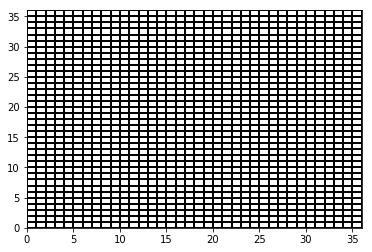


Temperature =  2.88
Mean Energy =  -0.8658333333333332
Mean Magnetization =  0.022083333333333333
Specific Heat =  0.30627402334819387
Susceptibility =  2.423733174725651
Monte Carlo Steps =  100  Accepted Moves =  56637


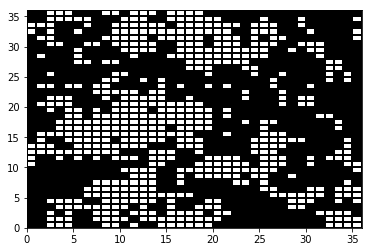


Temperature =  2.88
Mean Energy =  -0.8680555555555556
Mean Magnetization =  0.03167695473251029
Specific Heat =  0.45482742285538275
Susceptibility =  2.581078484606005
Monte Carlo Steps =  300  Accepted Moves =  168991


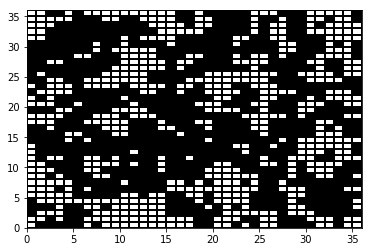

In [3]:
model = Ising2D(temperature=2.88, L=36)   # Tc = 2.3
figure(1)
model.plot()

show()

model.steps(number=20000)
model.reset()

model.steps(number=100)
model.observables()
figure(2)
model.plot()
show()

model.steps(number=200)
model.observables()
figure(3)
model.plot()

show()


In [ ]:
环境精致，24小时安保，有人代收快递。公寓资源有网球场，健身房，游泳池，停车场，洗衣机和烘干机，全年冷暖气冷热水供应.走路到Mall很近，可以看电影购物。步行到risd十分钟以内，到brown20多分钟。门口有公交车站，可到brown。跨一街区有公交站可以去罗德岛的两个中国超市，也可以直达whole foods market